In [3]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from matplotlib import colors, pyplot as plt
from numpy.random import normal, multivariate_normal 
from numpy.random import binomial

In [4]:
import sklearn
from sklearn.datasets import fetch_openml

In [5]:
#DEVICE = torch.device("cuda")
DEVICE = torch.device("cpu")
N_STEPS = 30

In [6]:
mnist = fetch_openml('mnist_784')
x = mnist.data
y = mnist.target

In [7]:
x = x.to_numpy()
print(np.max(x), np.min(x))

255.0 0.0


Binarized 

In [8]:
threshold = 128
x = (x >= threshold).astype(int)
x = (x - x.mean())/x.std()

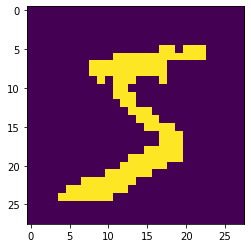

In [9]:
plt.imshow(x[0].reshape(28, 28))

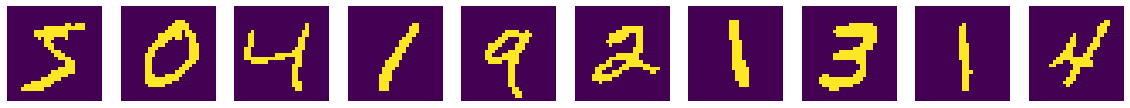

In [10]:
fig, axes = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    #print(test_sample[i].dtype)
    axes[i].imshow(x[i].reshape(28, 28))
    axes[i].axis('off')

In [11]:
def estimate_a_b_parameters(betas):
    param_dict = {}
    # creating dictionary of constants used while estimating prior and posterior distributions
    alphas = 1 - betas
    alphas_prod = torch.cumprod(alphas, 0)
    alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
    alphas_bar_sqrt = torch.sqrt(alphas_prod)
    one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
    one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
    post_mean_coef_1 = betas * torch.sqrt(alphas_prod_p / (1 - alphas_prod))
    post_mean_coef_2 = (1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod)
    post_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
    post_log_variance = torch.log(torch.cat((post_variance[1].view(1, 1), post_variance[1:].view(-1, 1)), 0)).view(-1)

    param_dict["betas"] = betas
    param_dict["alphas"] = alphas
    param_dict["alphas_prod"] = alphas_prod
    param_dict["alphas_bar_sqrt"] = alphas_bar_sqrt
    param_dict["one_minus_alphas_bar_log"] = one_minus_alphas_bar_log
    param_dict["one_minus_alphas_bar_sqrt"] = one_minus_alphas_bar_sqrt
    param_dict["post_mean_coef_1"] = post_mean_coef_1
    param_dict["post_mean_coef_2"] = post_mean_coef_2
    param_dict["post_variance"] = post_variance
    param_dict["post_log_variance"] = post_log_variance

    return param_dict

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)


def q_sample(x_0, t, param_dict, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(param_dict["alphas_bar_sqrt"], t, x_0)
    alphas_1_m_t = extract(param_dict["one_minus_alphas_bar_sqrt"], t, x_0)

    alphas_t = alphas_t.to(DEVICE)
    alphas_1_m_t = alphas_1_m_t.to(DEVICE)
    return alphas_t * x_0 + alphas_1_m_t * noise

def q_posterior_mean_variance(x_0, x_t, t, param_dict):
    coef_1 = extract(param_dict["post_mean_coef_1"], t, x_0)
    coef_2 = extract(param_dict["post_mean_coef_2"], t, x_0)

    coef_1 = coef_1.to(DEVICE)
    coef_2 = coef_2.to(DEVICE)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(param_dict["post_log_variance"], t, x_0)
    var = var.to(DEVICE)
    return mean, var

In [56]:
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=N_STEPS, start=1e-2, end=1e-2)
#betas = make_beta_schedule(schedule='sigmoid', n_timesteps=N_STEPS, start=1e-5, end=1e-1)

In [57]:
param_dict = estimate_a_b_parameters(betas)

In [58]:
class ConditionalLinear(nn.Module):
    
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y.to(DEVICE))
        out = gamma.view(-1, self.num_out) * out
        return out


class ConditionalModel(nn.Module):
    def __init__(self, size0, n_steps):
        super(ConditionalModel, self).__init__()
        self.flatten = nn.Flatten()
        self.lin1 = ConditionalLinear(size0, 1024, n_steps)
        self.lin2 = ConditionalLinear(1024, 2048, n_steps)
        self.lin3 = nn.Linear(2048, size0 * 2)
    
    def forward(self, x, y):
        x = self.flatten(x)
        #print("1", torch.count_nonzero(torch.isnan(x)))
        x = F.softplus(self.lin1(x, y))
        #print("2", torch.count_nonzero(torch.isnan(x)))
        x = F.softplus(self.lin2(x, y))
        #print("3", torch.count_nonzero(torch.isnan(x)))
        return self.lin3(x)


    
def p_mean_variance(model, x, t):
    out = model(x, t)
    #print(out.shape)
    mean, log_var = torch.split(out, 784, dim=-1)
    #print("mean size ", mean.shape, "log_var size ", log_var.shape)
    return mean, log_var

In [59]:
def p_sample(model, x, t):
    mean, log_var = p_mean_variance(model, x, torch.tensor(t))
    noise = torch.randn_like(x)
    shape = [x.shape[0]] + [1] * (x.ndimension() - 1)
    nonzero_mask = (1 - (t == 0))
    sample = mean + torch.exp(0.5 * log_var) * noise
    return (sample) 

In [60]:
def bin_p_sample_loop(model, shape):
    arr = abs(torch.randn(shape))
    probs = np.clip(arr, 0.0, 1.0)
    cur_x = torch.bernoulli(probs)
    x_seq = [cur_x]
    for i in reversed(range(N_STEPS)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

In [61]:
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(N_STEPS)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

In [62]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def entropy(val):
    return (0.5 * (1 + np.log(2. * np.pi))) + 0.5 * np.log(val)

In [63]:
def compute_loss(true_mean, true_var, model_mean, model_var, param_dict):
    # computing KL divergence between model prediction and true posterior
    KL = normal_kl(true_mean, true_var, model_mean, model_var).float()
    # computing conditional entropies x_t|x_0
    H_start = entropy(betas[0].float()).float()
    beta_full_trajectory = 1. - torch.exp(torch.sum(torch.log(param_dict["alphas"]))).float()
    H_end = entropy(beta_full_trajectory.float()).float()
    H_prior = entropy(torch.tensor([1.])).float()
    negL_bound = KL * N_STEPS + H_start - H_end + H_prior
    negL_gauss = entropy(torch.tensor([1.])).float()
    negL_diff = negL_bound - negL_gauss
    L_diff_bits = negL_diff / np.log(2.)
    L_diff_bits_avg = L_diff_bits.mean()
    return L_diff_bits_avg

In [64]:
last_states_dict = {}

In [65]:
def loss_likelihood_bound(model, x_0, param_dict):
    # selecting random timestep, calculating true posterior, making prediction and calculating loss value
    batch_size = x_0.shape[0]
    t = torch.randint(0, N_STEPS, size=(batch_size // 2 + 1,))
    t = torch.cat([t, N_STEPS - t - 1], dim=0)[:batch_size].long()
    x_t = q_sample(x_0, t, param_dict)
    last_states_dict[t[0]] = x_t
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t, param_dict)
    #print("true_mean.shape ", true_mean.shape, "true_var ", true_var.shape)
    model_mean, model_var = p_mean_variance(model, x_t, t)
    return compute_loss(true_mean, true_var, model_mean, model_var, param_dict)

In [66]:
import torch.optim as optim
size0 = 784 # size of flatten image
DEVICE = torch.device("cpu")
model = ConditionalModel(size0, N_STEPS).to(DEVICE)
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(x).float()
batch_size = 128

hist = []

# training cycle
for t in range(16):
    perm_0 = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        id = perm_0[i:i+batch_size]
        batch_x = dataset[id]
        loss = loss_likelihood_bound(model, batch_x, param_dict)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.) # feature for better training from paper
        optimizer.step()
    print(loss)
    hist.append(loss.detach()) 


tensor(64.6201, grad_fn=<MeanBackward0>)
tensor(62.1236, grad_fn=<MeanBackward0>)
tensor(58.1407, grad_fn=<MeanBackward0>)
tensor(57.9527, grad_fn=<MeanBackward0>)
tensor(58.5530, grad_fn=<MeanBackward0>)
tensor(58.3587, grad_fn=<MeanBackward0>)
tensor(57.8919, grad_fn=<MeanBackward0>)
tensor(56.7381, grad_fn=<MeanBackward0>)
tensor(56.3217, grad_fn=<MeanBackward0>)
tensor(54.5548, grad_fn=<MeanBackward0>)
tensor(54.8339, grad_fn=<MeanBackward0>)
tensor(54.2463, grad_fn=<MeanBackward0>)
tensor(51.6702, grad_fn=<MeanBackward0>)
tensor(53.2079, grad_fn=<MeanBackward0>)
tensor(52.6896, grad_fn=<MeanBackward0>)
tensor(51.4951, grad_fn=<MeanBackward0>)


In [67]:
test_sample = p_sample_loop(model, (1, 784))
print(test_sample[1].shape)

torch.Size([1, 784])


In [68]:
states = []
i = 0
for elem in last_states_dict.keys():
  i += 1
  #print(elem)
  if (i < 1000) and (i > 994):
    states.append(last_states_dict[elem])

In [82]:
def p_sample_loop_states(model, shape, j):
    #cur_x = states[j][1].reshape(shape)
    cur_x = states[j][3].reshape(shape)
    #print(cur_x.shape)
    x_seq = [cur_x]
    for i in reversed(range(N_STEPS)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

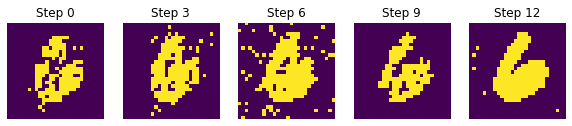

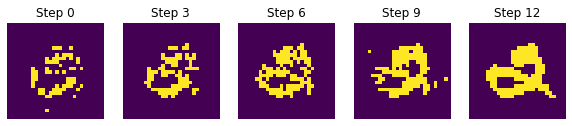

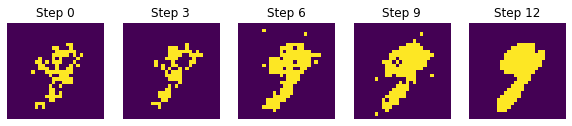

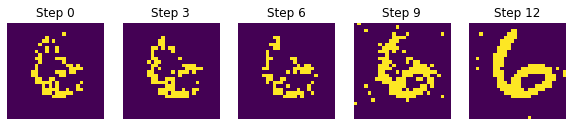

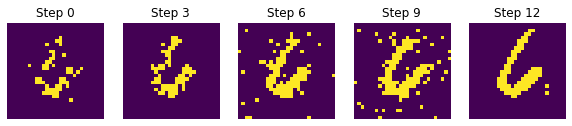

In [83]:
for j in range (5):
  threshold = 0
  test_sample = p_sample_loop_states(model, (1, 784), j)
  fig, axes = plt.subplots(1, 5, figsize=(10, 5))
  for i in range(5):
      pic = test_sample[12-3*i].detach().numpy()
      threshold = (np.max(pic) + np.min(pic)) / 2
      pic = (pic >= threshold).astype(int)
      axes[i].imshow(pic.reshape(28, 28))
      axes[i].axis('off')
      axes[i].set_title(f"Step{3*i}")

0
1
2
3
4


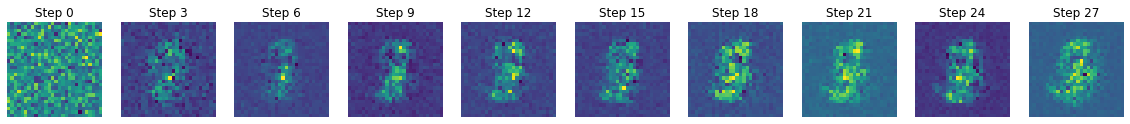

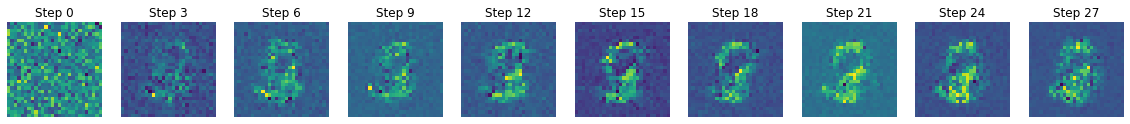

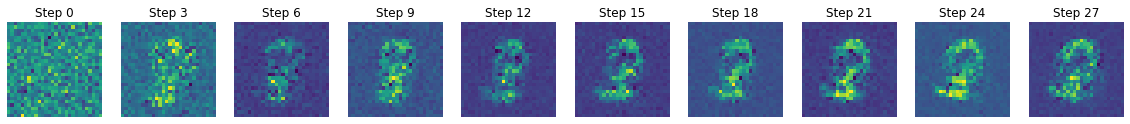

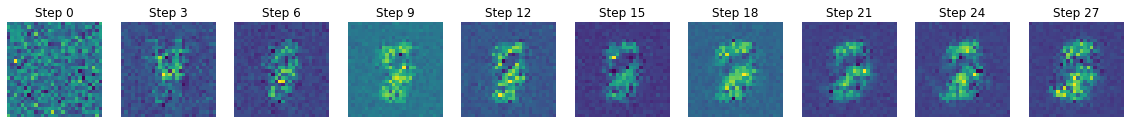

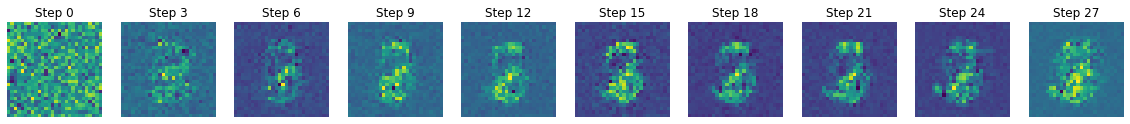

In [31]:
for j in range (5):
  test_sample = p_sample_loop(model, (1, 784))
  print(j)
  fig, axes = plt.subplots(1, 10, figsize=(20, 6))
  for i in range(10):
      #print(test_sample[i].dtype)
      pic = test_sample[3*i].detach().numpy()
      axes[i].imshow(pic.reshape(28, 28))
      axes[i].axis('off')
      axes[i].set_title(f"Step {3*i}")

In [ ]:
for j in range (5):
  test_sample = p_sample_loop(model, (1, 784))
  print(j)
  fig, axes = plt.subplots(1, 10, figsize=(20, 6))
  for i in range(10):
      #print(test_sample[i].dtype)
      pic = test_sample[i].detach().numpy()
      axes[i].imshow(pic.reshape(28, 28))
      axes[i].axis('off')
      axes[i].set_title(f"Step {i}")

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

lin1.lin.weight 	 torch.Size([1024, 784])
lin1.lin.bias 	 torch.Size([1024])
lin1.embed.weight 	 torch.Size([20, 1024])
lin2.lin.weight 	 torch.Size([2048, 1024])
lin2.lin.bias 	 torch.Size([2048])
lin2.embed.weight 	 torch.Size([20, 2048])
lin3.weight 	 torch.Size([1568, 2048])
lin3.bias 	 torch.Size([1568])


In [ ]:
weights = model.state_dict()
model = ConditionalModel(size0, N_STEPS).to(DEVICE)
model.load_state_dict(weights)